In [1]:
!pip install catboost -q
!pip install GPUtil -q
!pip install --upgrade --force-reinstall xlrd -q
!pip install pytorch-tabnet -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric

import gc
import os
from numpy import mean
from numpy import std

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#from sklearn.model_selection import GridSearchCV
#from scipy.stats import ks_2samp

In [3]:
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage() 
    torch.cuda.empty_cache()
    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

In [4]:
df = pd.read_excel('../input/taiwancd/default of credit card clients.xls', index_col = 0)

In [5]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
######### Pre-processing #########

In [7]:
df.rename({'default payment next month': 'target'}, axis=1, inplace=True)

In [8]:
#### Detect global outliers
ISF = IsolationForest(random_state=0)
df = df[ISF.fit_predict(df) == 1]

In [9]:
##### Detect local outliers
LOF = LocalOutlierFactor(n_neighbors=2)
df = df[LOF.fit_predict(df) == 1]

In [10]:
cat_cols=['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']

In [11]:
#One-Hot-Endcoding
df = pd.get_dummies(df, columns = cat_cols)

In [12]:
df.shape

(21901, 78)

In [13]:
y = df.target
df.drop('target', axis = 1, inplace = True)

In [14]:
#Normalize
scaler = StandardScaler()
X = scaler.fit_transform(df)

In [15]:
#Oversampling
sm = BorderlineSMOTE(random_state=42, n_jobs = -1)
X, y = sm.fit_resample(X, y)

In [16]:
gc.collect()

60604

In [17]:
############# Base model ############

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True, stratify = y)
print('Size of train dataframe: ', X_train.shape)
print('Size of train dataframe: ', y_train.shape)
print('Size of test dataframe: ', X_test.shape)
print('Size of train dataframe: ', y_test.shape)

Size of train dataframe:  (27790, 77)
Size of train dataframe:  (27790,)
Size of test dataframe:  (6948, 77)
Size of train dataframe:  (6948,)


In [19]:
n_fold = 5

In [20]:
############### Random Forest model #############

In [21]:
rf = RandomForestClassifier(n_estimators=361,
                               random_state=42,
                           n_jobs = -1,
                           verbose = 1)

In [22]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_rf = []
auc_score_rf = []
f1_rf = []
meta_train_rf = []
meta_test_rf = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    rf.fit(train_X, train_y)
    ####meta
    meta_train_rf = np.append(meta_train_rf, rf.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_rf) == 0:
        meta_test_rf = rf.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_rf = np.add(meta_test_rf, rf.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    
    yhat = rf.predict(X_test)
    acc_score_rf.append(accuracy_score(yhat,y_test))
    auc_score_rf.append(roc_auc_score(yhat,y_test))
    f1_rf.append(f1_score(yhat,y_test))
    i += 1
meta_test_rf = np.divide(meta_test_rf, n_fold)

KFold 1 of 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:   11.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks   

KFold 2 of 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:   11.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks   

KFold 3 of 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:   12.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks   

KFold 4 of 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:   11.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks   

KFold 5 of 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:   12.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks   

###Random Forest Classifier###

Accuracy: 0.8635866436384572 +- 0.0015959604232157803
ROC-AUC: 0.8639592254920359 +- 0.001608053217834987
F1-Score: 0.8657157489447982 +- 0.001609721327619085


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.4s finished


              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3474
           1       0.85      0.88      0.86      3474

    accuracy                           0.86      6948
   macro avg       0.86      0.86      0.86      6948
weighted avg       0.86      0.86      0.86      6948



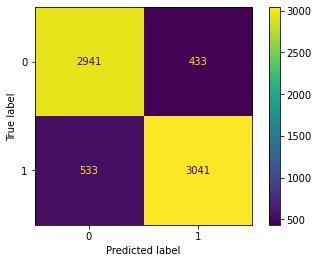

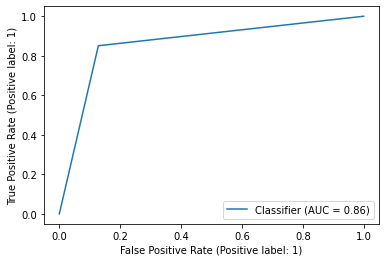

In [23]:
print("###Random Forest Classifier###\n")
print("Accuracy: " + str(mean(acc_score_rf)) + " +- "+ str(std(acc_score_rf)))
print("ROC-AUC: " + str(mean(auc_score_rf)) + " +- " + str(std(auc_score_rf)))
print("F1-Score: " + str(mean(f1_rf)) +" +- "+ str(std(f1_rf)))

yhat = rf.predict(X_test)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

In [24]:
gc.collect()

3155

In [25]:
######### LightGBM model ###########

In [26]:
lgb = LGBMClassifier(
                boosting_type='gbdt',
                max_depth=10,
                learning_rate=0.05,
                n_estimators=450,
                objective = 'binary',
                random_state=42
)

In [27]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_lgb = []
auc_score_lgb = []
f1_lgb = []
meta_train_lgb = []
meta_test_lgb = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    lgb.fit(train_X, train_y, eval_set=[(val_X, val_y)], early_stopping_rounds=200, verbose = 0)
    ####meta
    meta_train_lgb = np.append(meta_train_lgb, lgb.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_lgb) == 0:
        meta_test_lgb = lgb.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_lgb = np.add(meta_test_lgb, lgb.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    yhat = lgb.predict(X_test)
    acc_score_lgb.append(accuracy_score(yhat,y_test))
    auc_score_lgb.append(roc_auc_score(yhat,y_test))
    f1_lgb.append(f1_score(yhat,y_test))
    i += 1
meta_test_lgb = np.divide(meta_test_lgb, n_fold)


KFold 1 of 5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


KFold 2 of 5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


KFold 3 of 5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


KFold 4 of 5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


KFold 5 of 5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


###LightGBM Classifier###

Accuracy: 0.8725388601036268 +- 0.0021686595511614887
ROC-AUC: 0.8748572496518658 +- 0.0023749965450896695
F1-Score: 0.8673330816428617 +- 0.002036990669243342
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      3474
           1       0.91      0.83      0.87      3474

    accuracy                           0.87      6948
   macro avg       0.88      0.87      0.87      6948
weighted avg       0.88      0.87      0.87      6948



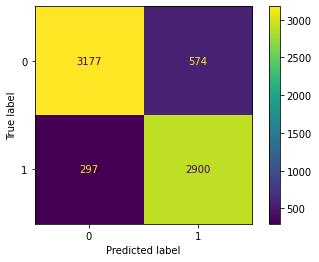

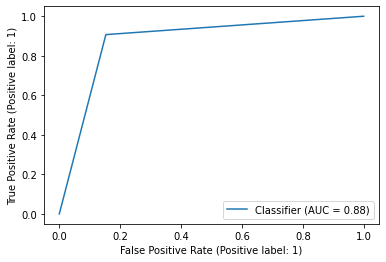

In [28]:
print("###LightGBM Classifier###\n")
print("Accuracy: " + str(mean(acc_score_lgb)) + " +- "+ str(std(acc_score_lgb)))
print("ROC-AUC: " + str(mean(auc_score_lgb)) + " +- " + str(std(auc_score_lgb)))
print("F1-Score: " + str(mean(f1_lgb)) +" +- "+ str(std(f1_lgb)))

yhat = lgb.predict(X_test)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

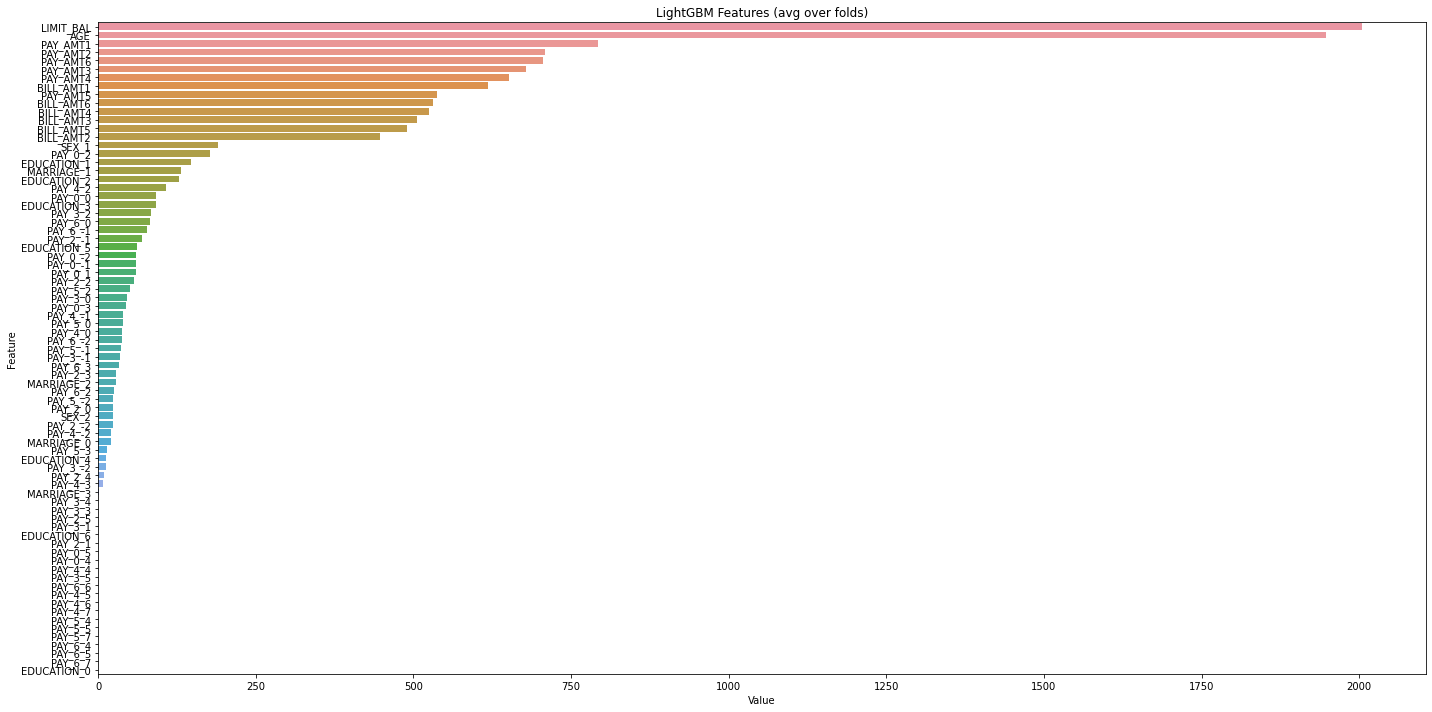

In [29]:
# feature_importances
feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_,df.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [30]:
gc.collect()

26346

In [31]:
######## XGBoost model ##########

In [32]:
xgb  = XGBClassifier(
 learning_rate =0.05,
 n_estimators=410,
 max_depth=18,
 min_child_weight=4,
 subsample=0.5,
 objective= 'binary:logistic',
 random_state=42,
 tree_method='gpu_hist',
 gpu_id=0)

In [33]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_xgb = []
auc_score_xgb = []
f1_xgb = []
meta_train_xgb = []
meta_test_xgb = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    xgb.fit(train_X, train_y, eval_set=[(val_X, val_y)], early_stopping_rounds=200, verbose = 0)
    ####meta
    meta_train_xgb = np.append(meta_train_xgb, xgb.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_xgb) == 0:
        meta_test_xgb = xgb.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_xgb = np.add(meta_test_xgb, xgb.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    yhat = xgb.predict(X_test)
    acc_score_xgb.append(accuracy_score(yhat,y_test))
    auc_score_xgb.append(roc_auc_score(yhat,y_test))
    f1_xgb.append(f1_score(yhat,y_test))
    i += 1
meta_test_xgb = np.divide(meta_test_xgb, n_fold)

KFold 1 of 5


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


KFold 2 of 5


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


KFold 3 of 5


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


KFold 4 of 5


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


KFold 5 of 5


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


###XGBoost Classifier###

Accuracy: 0.87426597582038 +- 0.002022356715054733
ROC-AUC: 0.8746335186229436 +- 0.002083946913678003
F1-Score: 0.8722756307183221 +- 0.0018933055785510338
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3474
           1       0.88      0.86      0.87      3474

    accuracy                           0.87      6948
   macro avg       0.87      0.87      0.87      6948
weighted avg       0.87      0.87      0.87      6948



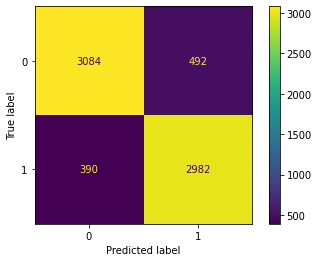

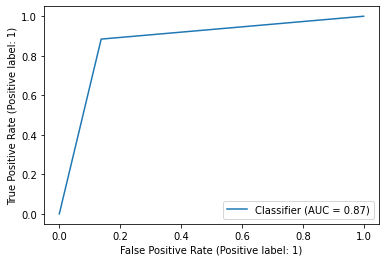

In [34]:
print("###XGBoost Classifier###\n")
print("Accuracy: " + str(mean(acc_score_xgb)) + " +- "+ str(std(acc_score_xgb)))
print("ROC-AUC: " + str(mean(auc_score_xgb)) + " +- " + str(std(auc_score_xgb)))
print("F1-Score: " + str(mean(f1_xgb)) +" +- "+ str(std(f1_xgb)))

yhat = xgb.predict(X_test)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

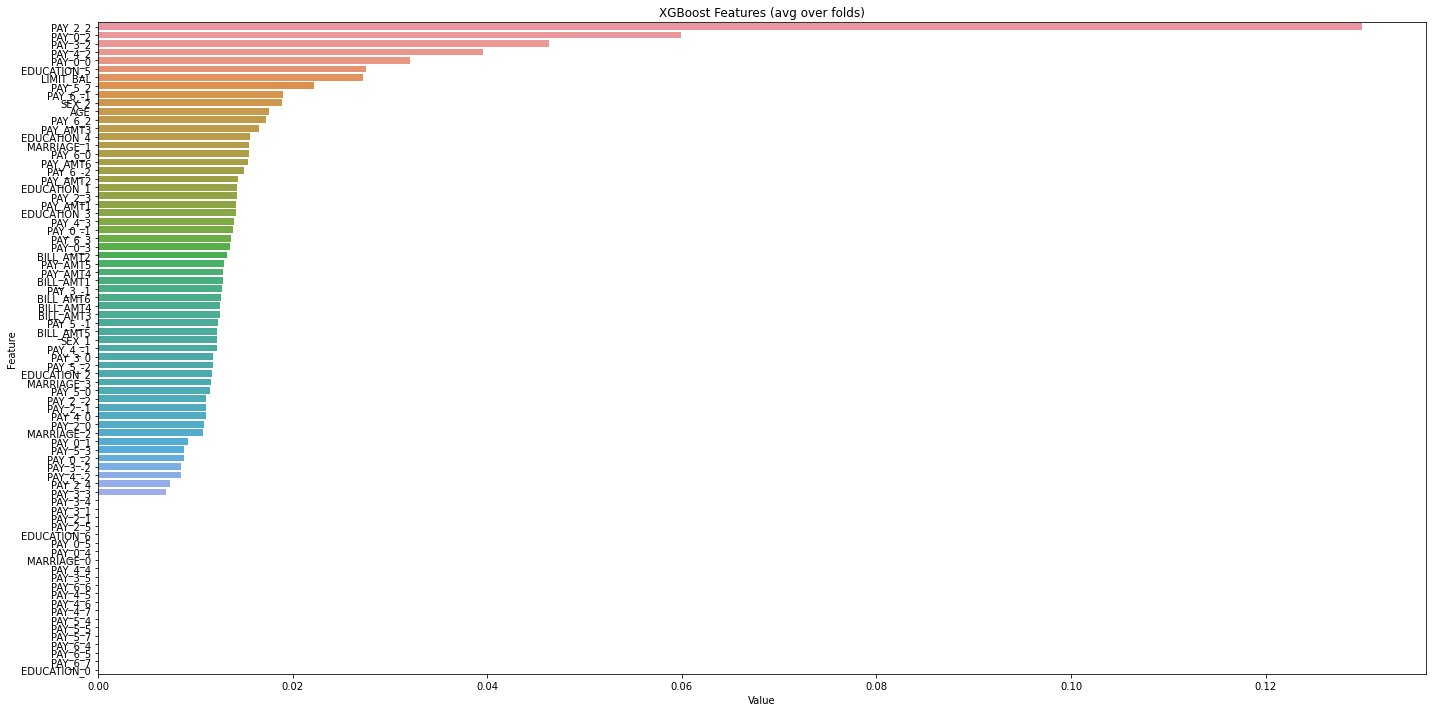

In [35]:
# feature_importances
feature_imp = pd.DataFrame(sorted(zip(xgb.feature_importances_,df.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features (avg over folds)')
plt.tight_layout()
plt.show()

In [36]:
gc.collect()

26207

In [37]:
############ CatBoost ################

In [38]:
catb = CatBoostClassifier(iterations=450,
                           learning_rate=0.05,
                           depth=10,
                          task_type = "GPU")

In [39]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_catb = []
auc_score_catb = []
f1_catb = []
meta_train_catb = []
meta_test_catb = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    catb.fit(train_X, train_y, eval_set=[(val_X, val_y)], early_stopping_rounds=200, verbose = 0)
    ####meta
    meta_train_catb = np.append(meta_train_catb, catb.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_catb) == 0:
        meta_test_catb = catb.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_catb = np.add(meta_test_catb, catb.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    yhat = catb.predict(X_test)
    acc_score_catb.append(accuracy_score(yhat,y_test))
    auc_score_catb.append(roc_auc_score(yhat,y_test))
    f1_catb.append(f1_score(yhat,y_test))
    i += 1
meta_test_catb = np.divide(meta_test_catb, n_fold)

KFold 1 of 5
KFold 2 of 5
KFold 3 of 5
KFold 4 of 5
KFold 5 of 5


###Catboost Classifier###

Accuracy: 0.8770293609671848 +- 0.0017967169296864973
ROC-AUC: 0.8781905812160808 +- 0.0017700899081583813
F1-Score: 0.8735330913277872 +- 0.0019306792071986313
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3474
           1       0.90      0.85      0.87      3474

    accuracy                           0.87      6948
   macro avg       0.88      0.87      0.87      6948
weighted avg       0.88      0.87      0.87      6948



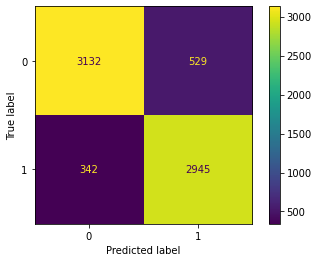

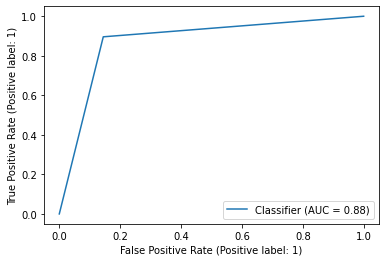

In [40]:
print("###Catboost Classifier###\n")
print("Accuracy: " + str(mean(acc_score_catb)) + " +- "+ str(std(acc_score_catb)))
print("ROC-AUC: " + str(mean(auc_score_catb)) + " +- " + str(std(auc_score_catb)))
print("F1-Score: " + str(mean(f1_catb)) +" +- "+ str(std(f1_catb)))

yhat = catb.predict(X_test)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

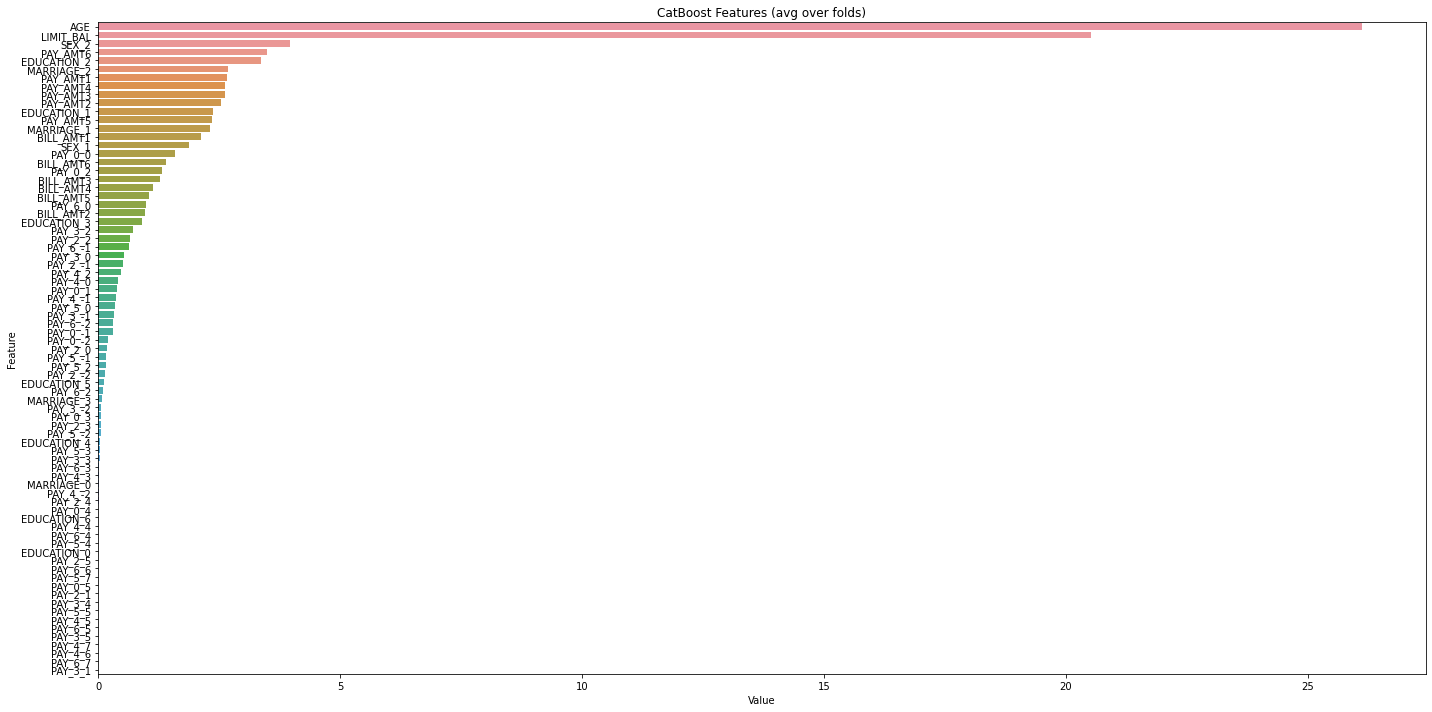

In [41]:
# feature_importances
feature_imp = pd.DataFrame(sorted(zip(catb.feature_importances_,df.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('CatBoost Features (avg over folds)')
plt.tight_layout()
plt.show()

In [42]:
gc.collect()
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  3% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 10% |  2% |


In [43]:
######### GBDT #############

In [44]:
gbdt = GradientBoostingClassifier(n_estimators=438,
                                  learning_rate=0.06,
                                  max_depth=10,
                                  subsample = 0.55,
                                  verbose = 1,
                                  random_state=0)

In [45]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_gbdt = []
auc_score_gbdt = []
f1_gbdt = []
meta_train_gbdt = []
meta_test_gbdt = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    gbdt.fit(train_X, train_y)
    ####meta
    meta_train_gbdt = np.append(meta_train_gbdt, gbdt.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_gbdt) == 0:
        meta_test_gbdt = gbdt.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_gbdt = np.add(meta_test_gbdt, gbdt.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    yhat = gbdt.predict(X_test)
    acc_score_gbdt.append(accuracy_score(yhat,y_test))
    auc_score_gbdt.append(roc_auc_score(yhat,y_test))
    f1_gbdt.append(f1_score(yhat,y_test))
    i += 1
meta_test_gbdt = np.divide(meta_test_gbdt, 5)

KFold 1 of 5
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3387           0.0340            1.23m
         2           1.3028           0.0296            1.23m
         3           1.2644           0.0305            1.24m
         4           1.2294           0.0273            1.24m
         5           1.1990           0.0230            1.24m
         6           1.1717           0.0219            1.24m
         7           1.1412           0.0230            1.24m
         8           1.1219           0.0159            1.24m
         9           1.1020           0.0169            1.24m
        10           1.0765           0.0158            1.24m
        20           0.8962           0.0106            1.22m
        30           0.7872           0.0063            1.24m
        40           0.7064           0.0036            1.21m
        50           0.6368           0.0046            1.18m
        60           0.5791           0.0026            

###GBDT Classifier###

Accuracy: 0.8802820955670697 +- 0.0017730412889389081
ROC-AUC: 0.8812803976857279 +- 0.001774879197840739
F1-Score: 0.8771447928313274 +- 0.0018421816396506018
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3474
           1       0.90      0.85      0.87      3474

    accuracy                           0.88      6948
   macro avg       0.88      0.88      0.88      6948
weighted avg       0.88      0.88      0.88      6948



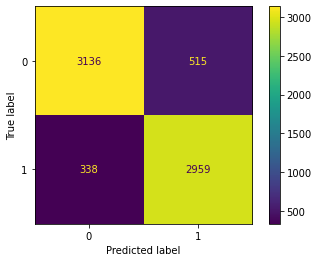

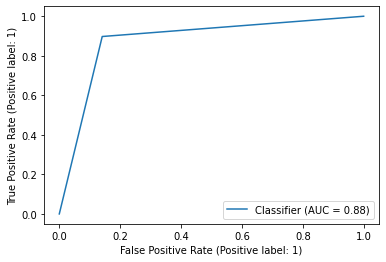

In [46]:
print("###GBDT Classifier###\n")
print("Accuracy: " + str(mean(acc_score_gbdt)) + " +- "+ str(std(acc_score_gbdt)))
print("ROC-AUC: " + str(mean(auc_score_gbdt)) + " +- " + str(std(auc_score_gbdt)))
print("F1-Score: " + str(mean(f1_gbdt)) +" +- "+ str(std(f1_gbdt)))

yhat = gbdt.predict(X_test)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

In [47]:
gc.collect()

8045

In [48]:
########### 1D-CNN model #############

In [49]:
def EarlyStop(patience):
    return EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=patience,
    verbose=0,
    mode="auto",
)

def ModelCheckpointFull(model_name):
    return ModelCheckpoint(
                     filepath=model_name, 
                     save_freq='epoch', verbose=1, monitor='val_accuracy', 
                     save_weights_only=True, save_best_only=True
                 )   

In [50]:
# Define 1D - CNN model
def create_model(input_shape):
    # Model Building
    model = Sequential()
    model = Sequential()
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=(input_shape,1)))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model




X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_train.shape[1], 1)

# 1D-CNN model
cnn1d = create_model(input_shape = X_train_cnn.shape[1])   


2022-11-12 12:35:26.898850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 12:35:26.900108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 12:35:26.900797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 12:35:26.901734: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_cnn1d = []
auc_score_cnn1d = []
f1_cnn1d = []
meta_train_cnn1d = []
meta_test_cnn1d = []
i = 1
for train_index, valid_index in kf.split(X_train_cnn, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train_cnn[train_index], X_train_cnn[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    cnn1d.fit(train_X, train_y, validation_data=(val_X, val_y), epochs = 500, 
            batch_size = 256, 
            callbacks = [EarlyStop(30), ModelCheckpointFull('./cnn1d.h5')],
            verbose = 1)
    ####meta
    meta_train_cnn1d = np.append(meta_train_cnn1d, cnn1d.predict(val_X))
    
    if len(meta_test_cnn1d) == 0:
        meta_test_cnn1d = cnn1d.predict(X_test_cnn)
    else:
        meta_test_cnn1d = np.add(meta_test_cnn1d, cnn1d.predict(X_test_cnn))
    #####
    yhat = cnn1d.predict(X_test_cnn).round()
    acc_score_cnn1d.append(accuracy_score(yhat,y_test))
    auc_score_cnn1d.append(roc_auc_score(yhat,y_test))
    f1_cnn1d.append(f1_score(yhat,y_test))
    i += 1
meta_test_cnn1d = np.divide(meta_test_cnn1d, 5)

###1D-CNN Classifier###

Accuracy: 0.8289867587795049 +- 0.006491315909688676
ROC-AUC: 0.8301924856597905 +- 0.005885370775631906
F1-Score: 0.8335291795339186 +- 0.004941581448744944
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      3474
           1       0.82      0.84      0.83      3474

    accuracy                           0.83      6948
   macro avg       0.83      0.83      0.83      6948
weighted avg       0.83      0.83      0.83      6948



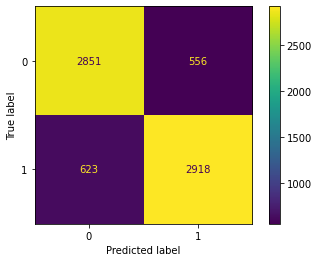

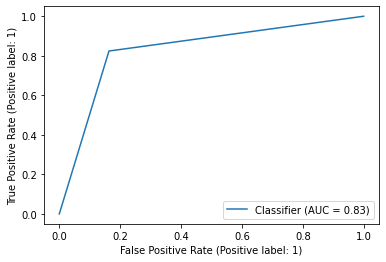

In [52]:
print("###1D-CNN Classifier###\n")
print("Accuracy: " + str(mean(acc_score_cnn1d)) + " +- "+ str(std(acc_score_cnn1d)))
print("ROC-AUC: " + str(mean(auc_score_cnn1d)) + " +- " + str(std(auc_score_cnn1d)))
print("F1-Score: " + str(mean(f1_cnn1d)) +" +- "+ str(std(f1_cnn1d)))

yhat = cnn1d.predict(X_test_cnn).round()
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

In [53]:
gc.collect()
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 98% |
GPU Usage after emptying the cache
| ID | GPU  | MEM |
-------------------
|  0 | 100% |  2% |


In [54]:
########### TabNet #############

In [55]:
class roc_auc(Metric):
    def __init__(self):
        self._name = "roc_auc"
        self._maximize = True

    def __call__(self, y_true, y_score):
        roc_auc = roc_auc_score(y_true, y_score[:, 1])
        return roc_auc

In [56]:
tabnet = TabNetClassifier(
                        n_d = 64,
                        n_a = 64,
                        n_steps = 3,
                        gamma = 1.3,
                        n_independent = 1,
                        n_shared = 2,
                        momentum = 0.02,
                        clip_value = None,
                        lambda_sparse = 1e-3,
                        optimizer_fn = torch.optim.Adam,
                        optimizer_params = dict(lr = 1e-3, weight_decay=1e-3),
                        scheduler_fn = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
                        scheduler_params = {'T_0':5,
                                            'eta_min':1e-4,
                                            'T_mult':1,
                                            'last_epoch':-1},
                        mask_type = 'entmax',
                        verbose = 1
)

/opt/conda/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_tabnet = []
auc_score_tabnet = []
f1_tabnet = []
meta_train_tabnet = []
meta_test_tabnet = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    tabnet.fit(train_X, train_y.ravel(),
      eval_set=[(val_X, val_y.ravel())],
      eval_metric=[roc_auc, "accuracy"],
      max_epochs = 500,
      patience = 50,
      batch_size = 256)
    ####meta
    meta_train_tabnet = np.append(meta_train_tabnet, tabnet.predict_proba(val_X)[:,1].reshape(-1,1))
    
    if len(meta_test_tabnet) == 0:
        meta_test_tabnet = tabnet.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_tabnet = np.add(meta_test_tabnet, tabnet.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    yhat = tabnet.predict(X_test).round()
    acc_score_tabnet.append(accuracy_score(yhat,y_test))
    auc_score_tabnet.append(roc_auc_score(yhat,y_test))
    f1_tabnet.append(f1_score(yhat,y_test))
    i += 1
meta_test_tabnet = np.divide(meta_test_tabnet, 5)

Accuracy: 0.8134139320667817 +- 0.009005969604097304
ROC-AUC: 0.821859925401158 +- 0.008341668626154715
F1-Score: 0.8274154694476155 +- 0.007640112259322687
              precision    recall  f1-score   support

           0       0.86      0.71      0.78      3474
           1       0.75      0.89      0.82      3474

    accuracy                           0.80      6948
   macro avg       0.81      0.80      0.80      6948
weighted avg       0.81      0.80      0.80      6948



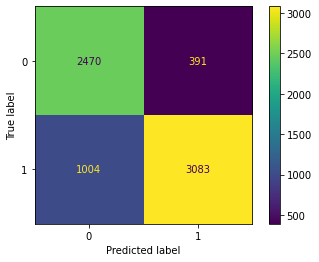

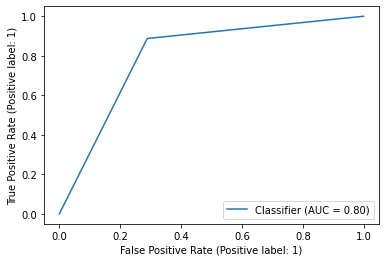

In [58]:
print("Accuracy: " + str(mean(acc_score_tabnet)) + " +- "+ str(std(acc_score_tabnet)))
print("ROC-AUC: " + str(mean(auc_score_tabnet)) + " +- " + str(std(auc_score_tabnet)))
print("F1-Score: " + str(mean(f1_tabnet)) +" +- "+ str(std(f1_tabnet)))


yhat = tabnet.predict(X_test).round()
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(y_test, yhat)
plt.show()

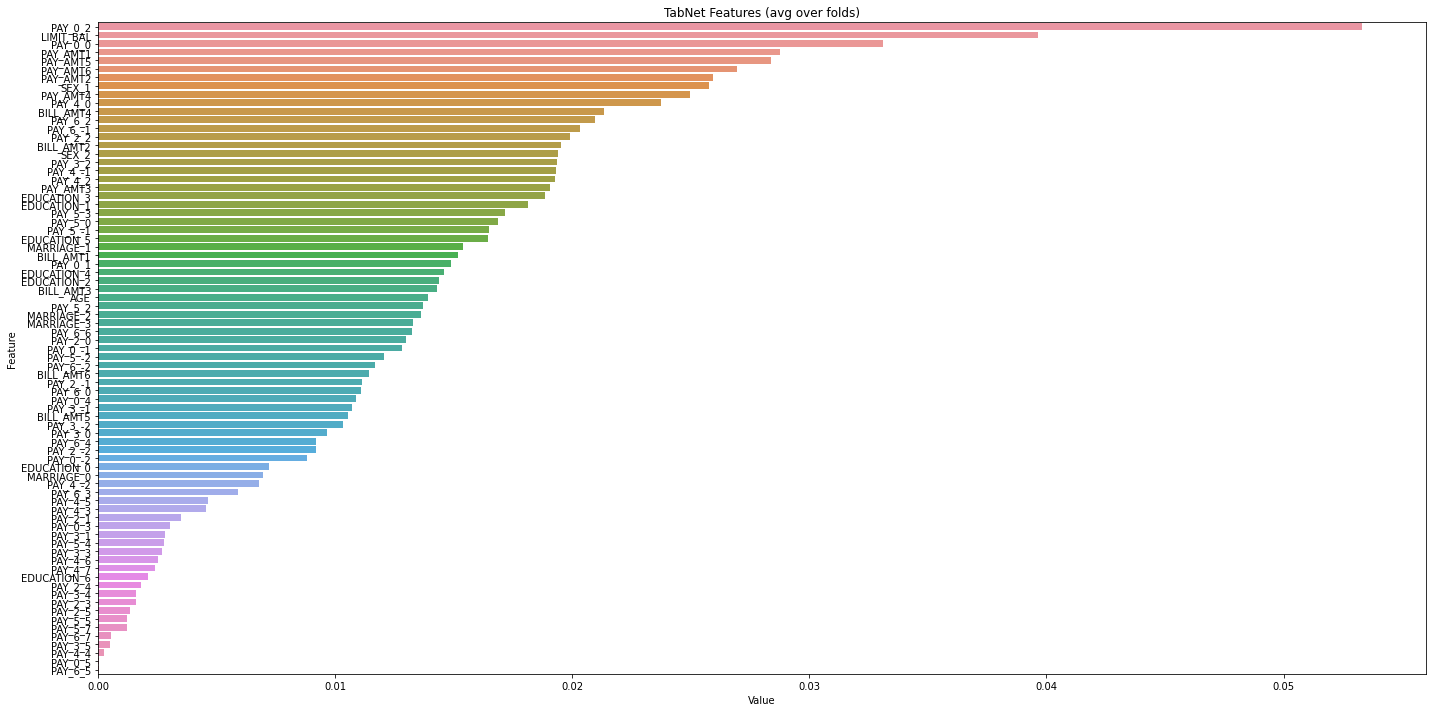

In [59]:
# feature_importances
feature_imp = pd.DataFrame(sorted(zip(tabnet.feature_importances_,df.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('TabNet Features (avg over folds)')
plt.tight_layout()
plt.show()

In [60]:
gc.collect()
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  6% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  9% |  2% |


In [61]:
################# STACKING #####################

In [62]:
meta_train = pd.concat([ pd.DataFrame(X_train, columns=df.columns),
                          pd.DataFrame(meta_train_rf, columns=['RF']),
                          pd.DataFrame(meta_train_lgb, columns=['LightGBM']),                        
                       pd.DataFrame(meta_train_xgb, columns=['XGBoost']),
                     pd.DataFrame(meta_train_catb, columns=['CatBoost']),
                        pd.DataFrame(meta_train_gbdt, columns=['GBDT']),
                        pd.DataFrame(meta_train_cnn1d, columns=['1DCNN']),
                       pd.DataFrame(meta_train_tabnet, columns=['TabNet'])], axis = 1)

In [63]:
meta_test = pd.concat([pd.DataFrame(X_test, columns=df.columns),
                          pd.DataFrame(meta_test_rf, columns=['RF']),
                          pd.DataFrame(meta_test_lgb, columns=['LightGBM']),                        
                       pd.DataFrame(meta_test_xgb, columns=['XGBoost']),
                     pd.DataFrame(meta_test_catb, columns=['CatBoost']),
                        pd.DataFrame(meta_test_gbdt, columns=['GBDT']),
                        pd.DataFrame(meta_test_cnn1d, columns=['1DCNN']),
                       pd.DataFrame(meta_test_tabnet, columns=['TabNet'])], axis = 1)

In [64]:
meta_train.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_5,PAY_6_6,PAY_6_7,RF,LightGBM,XGBoost,CatBoost,GBDT,1DCNN,TabNet
0,2.508524,0.413434,-0.496842,-0.540347,-0.316668,-0.280102,-0.222727,1.241321,0.866031,0.706699,...,-0.011705,-0.011705,-0.006757,0.229917,0.062836,0.052416,0.061596,0.044003,7.455358e-17,0.001127
1,0.080546,-1.074783,1.296749,1.414405,1.618187,1.594563,1.359432,1.309855,0.107667,0.361525,...,-0.011705,-0.011705,-0.006757,0.526316,0.867841,0.860227,0.759459,0.894146,9.996830e-01,0.670248
2,-1.130866,-1.126711,-0.471035,-0.536359,-0.494328,-0.505826,-0.456510,-0.409311,-0.255179,-0.332455,...,-0.011705,-0.011705,-0.006757,0.825485,0.898520,0.959293,0.848122,0.964371,8.970699e-01,0.745209
3,2.673951,2.276344,1.167828,1.308219,1.491390,1.669773,1.889856,1.976609,0.089151,0.147342,...,-0.011705,-0.011705,-0.006757,0.116343,0.084861,0.056717,0.053163,0.012121,2.914915e-09,0.051096
4,-0.882725,-1.339893,0.153932,0.195339,0.287944,0.375330,-0.531257,-0.502956,-0.259803,-0.222428,...,-0.011705,-0.011705,-0.006757,0.288089,0.445202,0.276373,0.286803,0.109840,9.360571e-03,0.071857


In [65]:
meta_test.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_5,PAY_6_6,PAY_6_7,RF,LightGBM,XGBoost,CatBoost,GBDT,1DCNN,TabNet
0,0.936969,-0.682395,2.055581,2.042280,2.106363,2.136651,2.139315,1.998151,0.058080,0.349663,...,-0.011705,-0.011705,-0.006757,0.088089,0.061550,0.041634,0.077437,0.015180,0.000123,0.033305
1,1.193527,0.840613,-0.795003,-0.794409,-0.795364,-0.778986,-0.762230,-0.744212,-0.396033,-0.460917,...,-0.011705,-0.011705,-0.006757,0.621607,0.833968,0.864602,0.797150,0.940171,0.792107,0.790019
2,0.027122,-0.024898,-0.337956,-0.289973,-0.174998,-0.128282,-0.060009,-0.000550,-0.239487,-0.007373,...,-0.011705,-0.011705,-0.006757,0.441551,0.240303,0.166701,0.222068,0.121552,0.076933,0.369077
3,-0.373146,-0.459792,0.477442,0.579551,0.477352,0.506088,0.653726,0.762401,-0.147281,-0.156796,...,-0.011705,-0.011705,-0.006757,0.603878,0.837718,0.928540,0.777256,0.955589,0.980957,0.719628
4,-1.130866,0.523017,-0.645137,-0.622341,-0.566977,-0.492742,-0.445278,-0.410146,-0.323837,-0.245397,...,-0.011705,-0.011705,-0.006757,0.438227,0.349192,0.384581,0.313744,0.329398,0.429506,0.555179


In [66]:
meta_train.to_pickle('meta_train.pkl')
meta_test.to_pickle('meta_test.pkl')

y_train.to_pickle('y_train.pkl')
y_test.to_pickle('y_test.pkl')